# Tokenze Text (Learn)
<a id="p1"></a>

In [1]:

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
#     tokens = list(doc_stream(path))
    tokens = yelp.lemma
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
#             stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

## Overview

> **token**: an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing

> [_*Introduction to Information Retrival*_](https://nlp.stanford.edu/IR-book/)


### The attributes of good tokens

* Should be stored in an iterable datastructure
  - Allows analysis of the "semantic unit"
* Should be all the same case
  - Reduces the complexity of our data
* Should be free of non-alphanumeric characters (ie punctuation, whitespace)
  - Removes information that is probably not relevant to the analysis

Let's pretend we are trying analyze the random sequence here. Question: what is the most common character in this sequence?

In [1]:
random_seq = "AABAAFBBBBCGCDDEEEFCFFDFFAFFZFGGGGHEAFJAAZBBFCZ"

A useful unit of analysis for us is going to be a letter or character

In [2]:
tokens = list(random_seq)
print(tokens)

['A', 'A', 'B', 'A', 'A', 'F', 'B', 'B', 'B', 'B', 'C', 'G', 'C', 'D', 'D', 'E', 'E', 'E', 'F', 'C', 'F', 'F', 'D', 'F', 'F', 'A', 'F', 'F', 'Z', 'F', 'G', 'G', 'G', 'G', 'H', 'E', 'A', 'F', 'J', 'A', 'A', 'Z', 'B', 'B', 'F', 'C', 'Z']


Our tokens are already "good": in an iterable datastructure, all the same case, and free of noise characters (punctionation, whitespace), so we can jump straight into analysis.

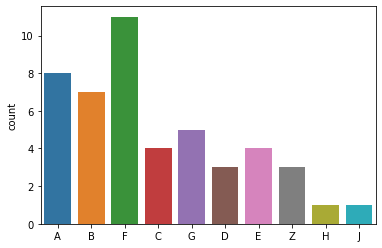

In [3]:
import seaborn as sns

sns.countplot(tokens);

The most common character in our sequence is  "F". We can't just glance at the the sequence to know which character is the most common. We (humans) struggle to subitize complex data (like random text sequences).

> __Subitize__ is the ability to tell the number of objects in a set, quickly, without counting.  

We need to chunk the data into countable pieces "tokens" for us to analyze them. This inability subitize text data is the motivation for our discussion today.

### Tokenizing with Pure Python

In [4]:
sample = "Friends, Romans, countrymen, lend me your ears;"

##### Iterable Tokens

A string object in Python is already iterable. However, the item you iterate over is a character not a token:

```
from time import sleep
for num, character in enumerate(sample):
    sleep(.5)
    print(f"Char {num} - {character}", end="\r")
```

If we instead care about the words in our sample (our semantic unit), we can use the string method `.split()` to seperate the whitespace and create iterable units. :)

In [5]:
sample.split(" ")

['Friends,', 'Romans,', 'countrymen,', 'lend', 'me', 'your', 'ears;']

##### Case Normalization
A common data cleaning data cleaning task with token is to standardize or normalize the case. Normalizing case reduces the chance that you have duplicate records for things which have practically the same semantic meaning. You can use either the `.lower()` or `.upper()` string methods to normalize case.

Consider the following example: 

In [6]:
import pandas as pd
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [7]:
# Notice anything odd here? 
df['brand'].value_counts()

Amazon          16153
Amazonbasics    12169
AmazonBasics       10
Name: brand, dtype: int64

In [8]:
# Much cleaner
df['brand'] = df['brand'].apply(lambda x: x.lower())
df['brand'].value_counts()

amazon          16153
amazonbasics    12179
Name: brand, dtype: int64

##### Keep Only Alphanumeric Characters
Yes, we only want letters and numbers. Everything else is probably noise: punctionation, whitespace, and other notation. This one is little bit more complicatd than our previous example. Here we will have to import the base package `re` (regular expressions). 

The only regex expression pattern you need for this is `'[^a-zA-Z ^0-9]'` which keeps lower case letters, upper case letters, spaces, and numbers.

In [9]:
sample = sample+" 911"
print(sample)

Friends, Romans, countrymen, lend me your ears; 911


In [10]:
import re

re.sub(r'[^a-zA-Z ^0-9]', '', sample)

'Friends Romans countrymen lend me your ears 911'

#### Two Minute Challenge 
- Complete the function `tokenize` below
- Combine the methods which we discussed above to clean text before we analyze it
- You can put the methods in any order you want

In [11]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [12]:
tokenize(sample)

['friends', 'romans', 'countrymen', 'lend', 'me', 'your', 'ears', '911']

## Follow Along

Our inability to analyze text data becomes quickly amphilfied in business context. Consider the following: 

A business which sells widgets also collects customer reviews of those widgets. When the business first started out, they had a human read the reviews to look for patterns. Now, the business sells thousands of widgets a month. The human readers can't keep up with the pace of reviews to synthesize an accurate analysis. They need some science to help them analyze their data.

Now, let's pretend that business is Amazon, and the widgets are Amazon products such as the Alexa, Echo, or other AmazonBasics products. Let's analyze their reviews with some counts. This dataset is available on [Kaggle](https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products/).

In [13]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer


nlp = spacy.load('en_core_web_lg')

In [14]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


In [15]:
# How can we count the raw text?
df['reviews.text'].value_counts(normalize=True)[:50]

good                0.002118
great               0.001729
Good                0.001482
Great               0.001341
ok                  0.001165
Great price         0.001059
great price         0.000988
Excellent           0.000988
Great value         0.000953
good price          0.000812
great value         0.000777
Great price!        0.000635
good value          0.000600
good deal           0.000565
Great value.        0.000565
OK                  0.000529
Great product       0.000529
Great deal          0.000529
As expected         0.000529
Good deal           0.000529
Good value          0.000494
Good batteries      0.000494
Great value!        0.000459
Great batteries.    0.000459
So far so good      0.000459
Good price          0.000459
great deal          0.000459
Work great          0.000424
Good buy            0.000424
Great deal!         0.000388
Great price.        0.000388
Good value.         0.000388
Great batteries     0.000388
As described        0.000388
as expected   

In [16]:
df['tokens'] = df['reviews.text'].apply(tokenize)

In [17]:
df['tokens'].head()

0    [i, order, 3, of, them, and, one, of, the, ite...
1    [bulk, is, always, the, less, expensive, way, ...
2    [well, they, are, not, duracell, but, for, the...
3    [seem, to, work, as, well, as, name, brand, ba...
4    [these, batteries, are, very, long, lasting, t...
Name: tokens, dtype: object

In [52]:
df[['reviews.text', 'tokens']][:10]

,reviews.text,tokens
0,I order 3 of them and one of the item is bad q...,"[order, 3, item, bad, quality., missing, backu..."
1,Bulk is always the less expensive way to go fo...,"[bulk, expensive, way, products, like]"
2,Well they are not Duracell but for the price i...,"[duracell, price, happy.]"
3,Seem to work as well as name brand batteries a...,"[work, brand, better, price]"
4,These batteries are very long lasting the pric...,"[long, lasting, price, great.]"
5,Bought a lot of batteries for Christmas and th...,"[bought, lot, christmas, amazonbasics, cell, g..."
6,ive not had any problame with these batteries ...,"[ive, problame, ordered, past, pleased.]"
7,Well if you are looking for cheap non-recharge...,"[looking, cheap, non-rechargeable, perfect., s..."
8,These do not hold the amount of high power jui...,"[hold, high, power, juice, like, energizer, du..."
9,AmazonBasics AA AAA batteries have done well b...,"[amazonbasics, aa, aaa, appear, good, shelf, l..."


#### Analyzing Tokens

In [18]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
df['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('the', 28836),
 ('and', 22302),
 ('i', 20588),
 ('to', 19537),
 ('for', 17918),
 ('a', 17599),
 ('it', 16793),
 ('is', 11482),
 ('my', 11149),
 ('this', 10420)]

Let's create a fuction which takes a corpus of document and returns and dataframe of word counts for us to analyze.

In [19]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [20]:
# Use the Function
wc = count(df['tokens'])

In [21]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
13,the,13185,28836,1.0,0.039350,0.039350,0.465375
22,and,13731,22302,2.0,0.030434,0.069784,0.484646
6,i,10301,20588,3.0,0.028095,0.097879,0.363582
2,to,11312,19537,4.0,0.026661,0.124539,0.399266
30,for,12101,17918,5.0,0.024451,0.148990,0.427114


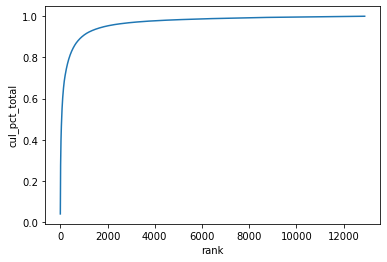

In [22]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [23]:
wc[wc['rank'] <= 20]['cul_pct_total'].max()

0.3353465992363599

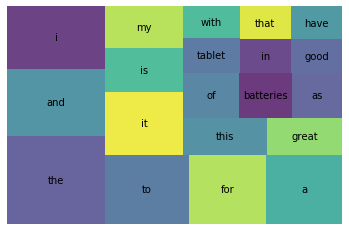

In [24]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

### Processing Raw Text with Spacy

Spacy's datamodel for documents is unique among NLP libraries. Instead of storing the documents components repeatively in various datastructures, Spacy indexes components and simply stores the lookup informaiton. 

This is often why Spacy is considered to be more production grade than library like NLTK.

In [25]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [26]:
# Print out list of tokens
[token.text for token in tokenizer(sample)]

['Friends,', 'Romans,', 'countrymen,', 'lend', 'me', 'your', 'ears;', '911']

In [27]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df['tokens'] = tokens

In [28]:
df['tokens'].head()

0    [I, order, 3, of, them, and, one, of, the, ite...
1    [Bulk, is, always, the, less, expensive, way, ...
2    [Well, they, are, not, Duracell, but, for, the...
3    [Seem, to, work, as, well, as, name, brand, ba...
4    [These, batteries, are, very, long, lasting, t...
Name: tokens, dtype: object

In [29]:
wc = count(df['tokens'])

In [30]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
12,the,12316,25154,1.0,0.034219,0.034219,0.434703
22,and,13541,21850,2.0,0.029725,0.063944,0.477940
25,I,9913,19762,3.0,0.026884,0.090828,0.349887
2,to,11227,19324,4.0,0.026288,0.117117,0.396266
31,for,11790,17197,5.0,0.023395,0.140512,0.416137


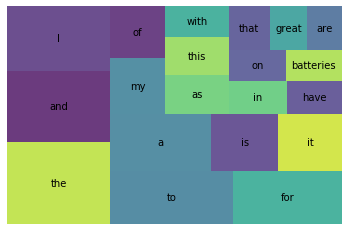

In [31]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Challenge

In the module project, you will apply tokenization to another set of review data and produce visualizations of those tokens. 

# Stop Words (Learn)
<a id="p2"></a>

## Overview
Section Agenda
- What are they?
- How do we get rid of them using Spacy?
- Visualization
- Libraries of Stop Words
- Extending Stop Words
- Statistical trimming

If the visualizations above, you began to notice a pattern. Most of the words don't really add much to our undertanding of product reviews. Words such as "I", "and", "of", etc. have almost no semantic meaning to us. We call these useless words "stop words," because we should 'stop' ourselves from including them in the analysis. 

Most NLP libraries have built in lists of stop words that common english words: conjunctions, articles, adverbs, pronouns, and common verbs. The best practice, however, is to extend/customize these standard english stopwords for your problem's domain. If I am studying political science, I may want to exclude the word "politics" from my analysis; it's so common it does not add to my understanding. 

## Follow Along 

### Default Stop Words
Let's take a look at the standard stop words that came with our spacy model:

In [32]:
# Spacy's Default Stop Words
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [33]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [34]:
df.tokens.head()

0    [order, 3, item, bad, quality., missing, backu...
1               [bulk, expensive, way, products, like]
2                            [duracell, price, happy.]
3              [work, brand, batteries, better, price]
4            [batteries, long, lasting, price, great.]
Name: tokens, dtype: object

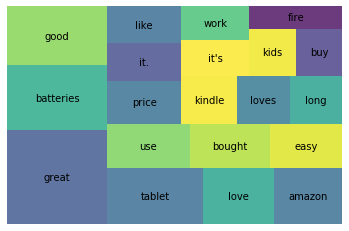

In [35]:
wc = count(df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

### Extending Stop Words

In [36]:
print(type(nlp.Defaults.stop_words))

<class 'set'>


In [37]:
STOP_WORDS = nlp.Defaults.stop_words.union(['batteries','I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this',])

In [38]:
STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'Amazon',
 'I',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amazon',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'batteries',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'for

In [39]:
tokens = []

for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [40]:
wc = count(df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
73,great,7187,8183,1.0,0.023959,0.023959,0.253671
64,good,4633,5148,2.0,0.015073,0.039032,0.163525
7808,tablet,3920,4714,3.0,0.013802,0.052834,0.138359
113,love,3154,3458,4.0,0.010125,0.062958,0.111323
103,use,2881,3233,5.0,0.009466,0.072424,0.101687


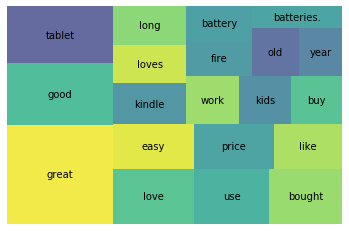

In [41]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [42]:
df['reviews.rating'].value_counts()

5    19897
4     5648
3     1206
1      965
2      616
Name: reviews.rating, dtype: int64

### Statistical Trimming

So far, we have talked about stop word in relation to either broad english words or domain specific stop words. Another common approach to stop word removal is via statistical trimming. The basic idea: preserve the words that give the most about of variation in your data. 

Do you remember this graph?

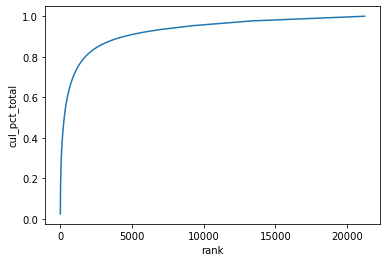

In [43]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

This graph tells us that only a *handful* of words represented 80% of words in the overall corpus. We can interpret this in two ways: 
1. The words that appear most frequently may not provide any insight into the mean on the documens since they are so prevalent. 
2. Words that appear infrequeny (at the end of the graph) also probably do not add much value, because the are mentioned so rarely. 

Let's take a look at the words at the bottom and the top and make a decision for ourselves:

In [44]:
wc.tail(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
21200,cares,1,1,21201.0,0.000003,0.999944,0.000035
21201,photo/video,1,1,21202.0,0.000003,0.999947,0.000035
21202,"taking,",1,1,21203.0,0.000003,0.999950,0.000035
21203,"""t"".",1,1,21204.0,0.000003,0.999953,0.000035
21205,say..............................................,1,1,21205.0,0.000003,0.999956,0.000035
21204,kindlelishous!!!!!!!!!!!!!,1,1,21206.0,0.000003,0.999959,0.000035
21206,"competent,",1,1,21207.0,0.000003,0.999962,0.000035
21207,"3-year-old,",1,1,21208.0,0.000003,0.999965,0.000035
21208,dollars.my,1,1,21209.0,0.000003,0.999968,0.000035
21209,relies,1,1,21210.0,0.000003,0.999971,0.000035


In [45]:
wc['appears_in_pct'].describe()

count    21220.000000
mean         0.000538
std          0.003705
min          0.000035
25%          0.000035
50%          0.000071
75%          0.000176
max          0.253671
Name: appears_in_pct, dtype: float64

C:\Users\daani\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


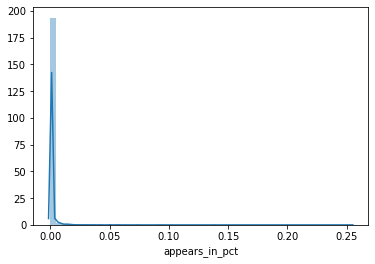

In [46]:
# Frequency of appears in documents
sns.distplot(wc['appears_in_pct']);

C:\Users\daani\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


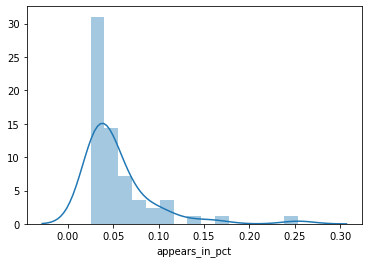

In [47]:
# Tree-Map w/ Words that appear in a least 2.5% of documents. 

wc = wc[wc['appears_in_pct'] >= 0.025]

sns.distplot(wc['appears_in_pct']);

## Challenge

In the module project, you will apply stop word removal to a new corpus. You will focus on applying dictionary based stop word removal, but as a stretch goal, you should consider applying statistical stopword trimming. 

# Stemming & Lemmatization (Learn)
<a id="p3"></a>

## Overview

You can see from our example above there is still some normalization to do to get a clean analysis. You notice that there many words (*i.e.* 'batteries', 'battery') which share the same root word. We can use either the process of stemming or lemmatization to trim our words down to the 'root' word. 

__Section Agenda__:

- Which is which
- why use one v. other
- show side by side visualizations 
- how to do it in spacy & nltk
- introduce PoS in here as well

## Follow Along

### Stemming

> *a process for removing the commoner morphological and inflexional endings from words in English. Its main use is as part of a term normalisation process that is usually done when setting up Information Retrieval systems.* - [Martin Porter](https://tartarus.org/martin/PorterStemmer/)

Some examples include:
- 'ing'
- 'ed'
- 's'

These rules are by no means comprehensive, but they are somewhere to start. Most stemming is done by well documented algorithms such as Porter, Snowball, and Dawson. Porter and its newer version Snowball are the most popular stemming algorithms today. For more information on various stemming algorithms check out [*"A Comparative Study of Stemming Algorithms"*](https://pdfs.semanticscholar.org/1c0c/0fa35d4ff8a2f925eb955e48d655494bd167.pdf) 


Spacy does not do stemming out of the box, but instead uses a different technique called *lemmatization* which we will discuss in the next section. Let's turn to an antique python package `nltk` for stemming. 

In [48]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

words = ["python", "pythoner", "pythoning", "pythoned", "pythonly"]

for word in words:
    print(ps.stem(word))

python
python
python
python
pythonli


### Two Minute Challenge

Apply the Porter stemming algorithm to the tokens in the `df` dataframe. Visualize the results in the tree graph we have been using for this session.

In [49]:
# Put in a new column `stems`


In [50]:
wc = count(df['stems'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

KeyError: 'stems'

### Lemmatization

You notice immediately that results are kinda funky - words just oddly chopped off. The Porter algorithm did exactly what it knows to do: chop off endings. Stemming works well in applications where humans don't have to worry about reading the results. Search engines and more broadly information retrival algorithms use stemming. Why? Becuase it's fast. 

Lemmatization on the other hand is more methodical. The goal is to transform a word into's base form called a lemma. Plural nouns with funky spellings get transformed to singular tense. Verbs are all transformed to the transitive. Nice tidy data for a visualization. :) However, this tidy data can come at computational cost. Spacy does a pretty freaking good job of it though. Let's take a look:

In [53]:
sent = "This is the start of our NLP adventure. We started here with Spacy."

nlp = spacy.load("en_core_web_lg")

doc = nlp(sent)

# Lemma Attributes
for token in doc:
    print(token.text, "  ", token.lemma_)

This    this
is    be
the    the
start    start
of    of
our    -PRON-
NLP    NLP
adventure    adventure
.    .
We    -PRON-
started    start
here    here
with    with
Spacy    Spacy
.    .


In [54]:
# Wrap it all in a function
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [57]:
df['lemmas'] = df['reviews.text'].apply(get_lemmas)

In [58]:
df['lemmas'].head()

0    [order, 3, item, bad, quality, miss, backup, s...
1                [Bulk, expensive, way, product, like]
2                             [Duracell, price, happy]
3                  [work, brand, battery, well, price]
4                  [battery, long, last, price, great]
Name: lemmas, dtype: object

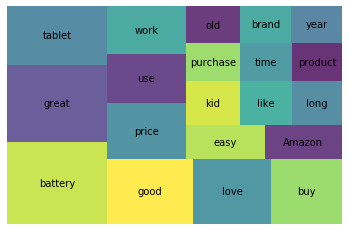

In [59]:
wc = count(df['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Challenge

You should know how to apply lemmatization with Spacy to a corpus of text. 

# Review

In this module project, you've seen us apply Natural Language Processing techniques (tokenization, stopword removal, and lemmatization) to a corpus of Amazon text reviews. We analyzed those reviews using these techniques and discovered that Amazon customers are generally statisfied with the battery life of Amazon products and generally appear statisfied. 

You will apply similiar techniques to today's [module project assignment](LS_DS_411_Text_Data_Assignment.ipynb) to analyze coffee shop reviews from yelp. Remeber that the techniques of processing the text are just the begining. There are many ways to slice and dice the data. 

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf

## Advanced Resources & Techniques
- Named Entity Recognition (NER)
- Dependcy Trees 
- Generators
- the major libraries (NLTK, Spacy, Gensim)